In [1]:
# Referred to the following blog
# https://qiita.com/yoshizaki_kkgk/items/79f4056901dd9c059afb

import time
import poloniex
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

# poloniex APIの準備
polo = poloniex.Poloniex()

# 5分間隔（サンプリング間隔300秒）で100日分読み込む
chart_data = polo.returnChartData('BTC_ETH', period=300, start=time.time()-polo.DAY*100, end=time.time())
#print(chart_data)

# pandasにデータの取り込み
df = pd.DataFrame(chart_data)
# df.head(10)
# df['close']

# 短期線：窓幅1日（5分×12×24）
data_s = pd.rolling_mean(df['close'], 12 * 24) 
# 長期線：窓幅5日（5分×12×24×5）
data_l = pd.rolling_mean(df['close'], 12 * 24 * 5)

# 短期線と長期線もプロット
plt.plot(df['close'], color='#7f8c8d')
plt.plot(data_s, color='#f1c40f')  # 短期線
plt.plot(data_l, color='#2980b9')  # 長期線
plt.show()

/Users/onikut/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=288,center=False).mean()
/Users/onikut/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1440,center=False).mean()


In [2]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions

/Users/onikut/.pyenv/versions/3.6.4/lib/python3.6/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [3]:
# 線形代数の演算でよく使うnumpyの読み込み
import numpy as np

# API経由では文字列（String型）として受け取るため、float型に変換しておく
# また、Chainerではfloat32を推奨しているため、こちらに合わせておく
data = df['close'].astype(np.float32)
#data = df['close']

# データを入力変数xと出力変数tに切り分け
x, t = [], []
N = len(data)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
    # 入力変数と出力変数の切り分け
    _x = data[n-M: n] # 入力変数
    _t = data[n] # 出力変数
    # 計算用のリスト(x, t)に追加していく
    x.append(_x)
    t.append(_t)
    
# numpyの形式に変換する（何かと便利なため）
x = np.array(x)
t = np.array(t).reshape(len(t), 1)  

# 70%を訓練用、30%を検証用
N_train = int(N * 0.7)
x_train, x_test = x[:N_train], x[N_train:]
t_train, t_test = t[:N_train], t[N_train:]

# PFNの開発者推奨の方法
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))
t_train, t_test = t[:N_train], t[N_train:]

In [4]:
class LSTM(Chain):
    # モデルの構造を明記
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units) # LSTMの層を追加
            self.l2 = L.Linear(None, n_output)

    # LSTM内で保持する値をリセット
    def reset_state(self):
        self.l1.reset_state()

    # 損失関数の計算
    def __call__(self, x, t, train=True):
        y = self.predict(x, train)
        loss = F.mean_squared_error(y, t)
        if train:
            report({'loss': loss}, self)
        return loss

    # 順伝播の計算
    def predict(self, x, train=False):
        l1 = self.l1(x)
        h2 = self.l2(h1)
        return h2

In [5]:
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater, self).__init__(data_iter, optimizer, device=None)
        self.device = device

    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")

        batch = data_iter.__next__()
        x_batch, y_batch = chainer.dataset.concat_examples(batch, self.device)

        # ↓ ここで reset_state() を実行できるようにしている
        optimizer.target.reset_state()

        # その他は時系列系の更新と同じ
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, y_batch)
        loss.backward()
        # 時系列ではunchain_backward()によって計算効率が上がるそう
        loss.unchain_backward()
        optimizer.update()

In [6]:
class LSTM(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)

    def reset_state(self):
        self.l1.reset_state()

    def __call__(self, x, t, train=True):
        y = self.predict(x, train)
        loss = F.mean_squared_error(y, t)
        if train:
            report({'loss': loss}, self)
        return loss

    def predict(self, x, train=False):
        # ドロップアウトの追加（訓練時のみ使うようにする）
        if train:
            h1 = F.dropout(self.l1(x), ratio=0.05)
        else:
            h1 = self.l1(x)
        h2 = self.l2(h1)
        return h2

In [7]:
# chainer用のデータセットでメモリに乗る程度であれば、list(zip(...))を推奨
# ↑ PFNの開発者推奨の方法
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))

# 再現性確保
np.random.seed(1)

# モデルの宣言
model = LSTM(30, 1)

# optimizerの定義
optimizer = optimizers.Adam()  # 最適化アルゴリズムはAdamを使用
optimizer.setup(model)

# iteratorの定義
batchsize = 20
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# updaterの定義
updater = LSTMUpdater(train_iter, optimizer)

# trainerの定義
epoch = 30
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
# trainerの拡張機能
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport(trigger=(1,'epoch')))

# 1エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           1.56548e-05  0.137864              2.38506       
2           3.23841e-06  0.105073              5.45507       
3           2.08704e-06  0.062658              8.14319       
4           1.67284e-06  0.0593442             10.8445       
5           1.4499e-06  0.0675732             13.1058       
6           1.33648e-06  0.0673298             15.3132       
7           1.24352e-06  0.0610874             17.8438       
8           1.16839e-06  0.0665154             20.3658       
9           1.19685e-06  0.0593103             22.6895       
10          1.09939e-06  0.0575995             25.414        
11          1.16054e-06  0.0620204             27.6534       
12          1.11103e-06  0.0518352             30.0824       
13          1.0646e-06  0.0539182             33.1186       
14          1.06315e-06  0.0553028             35.6775       
15          1.05932e-06  0.0572193             38.4105       
16          1

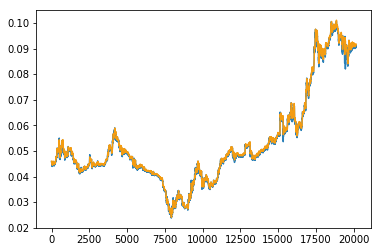

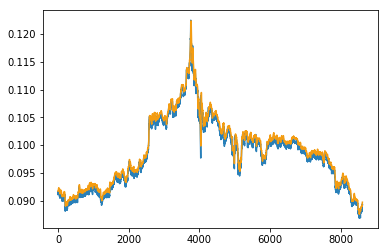

In [8]:
# 予測値の計算
model.reset_state()
y_train = model.predict(Variable(x_train)).data

# プロット
plt.plot(t_train, color='#2980b9') # 実測値は青色
plt.plot(y_train, color='#f39c12') # 予測値はオレンジ
plt.show()

# 予測値の計算
model.reset_state()
y_test = model.predict(Variable(x_test)).data

# プロット
plt.plot(t_test, color='#2980b9')  # 実測値は青色
plt.plot(y_test, color='#f39c12')  # 予測値はオレンジ
plt.show()